In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_friedman2
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF, ExpSineSquared,Matern,ConstantKernel
import random

In [37]:
#read the data and create data frame
df = pd.read_csv('heart_rate_data.csv')
df['time'] = np.linspace(0, 900, len(df))
df.columns = ['Y','time']
df

,Y,time
0,84.2697,0.000000
1,84.0619,0.500556
2,85.6542,1.001112
3,87.2093,1.501669
4,87.1246,2.002225
...,...,...
1794,103.7900,897.997775
1795,101.6230,898.498331
1796,99.5679,898.998888
1797,99.1835,899.499444


In [38]:
train_size = 150 #at the head
test_size = 100 #in the middle
train_size2 = 150 #at the tail
split = train_size + test_size + train_size2

#get training set
train = df[0:train_size].append(df[train_size + test_size:split]) 
X_train = np.array(train['time']).reshape(-1, 1)
Y_train = np.array(train['Y']).reshape(-1, 1)

#get testing set
test = df[train_size-1:train_size+test_size+1]
X_test = np.array(test['time']).reshape(-1, 1)
Y_test = np.array(test['Y']).reshape(-1, 1)

# Below df are only used for poltting the data
# we add nan in between 2 parts of training data to avoid the straight line between twp training set in later plotting
df_train_two_side = df.copy(deep=True)
df_train_two_side['Y'][train_size:train_size+test_size] = np.nan
train_2_side = df_train_two_side[0:split]
X_train_with_nan = np.array(train_2_side['time']).reshape(-1, 1) 
Y_train_with_nan = np.array(train_2_side['Y']).reshape(-1, 1)    

/var/folders/ts/xc6_h0kd5nv7gws_x4n04jwr0000gn/T/ipykernel_18091/711850680.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = df[0:train_size].append(df[train_size + test_size:split])


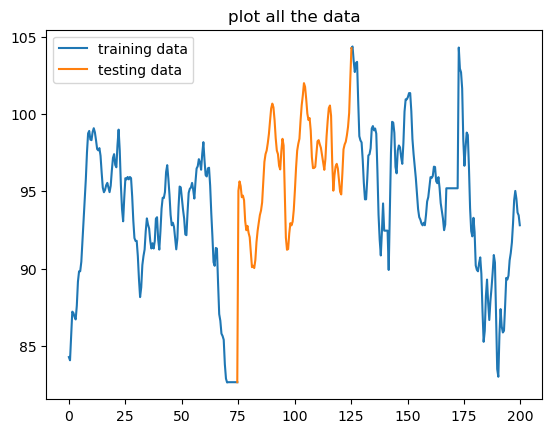

In [39]:
#plot all the data
plt.figure()
plt.title('plot all the data')
plt.plot(X_train_with_nan, Y_train_with_nan, label = 'training data')
plt.plot(X_test,Y_test, label = 'testing data')
plt.legend()

In [40]:
#set random seed to make result more consistant
random.seed(10)

Design Kernal and GP model

In [151]:
# kernel = ConstantKernel(3) * ExpSineSquared() + RBF() + WhiteKernel()
kernel = ConstantKernel(3) * ExpSineSquared() + RBF()+ WhiteKernel(0.95)
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, random_state = random.seed(10))

In [152]:
# Fit to data using MLE
gp.fit(X_train, Y_train)

GaussianProcessRegressor(kernel=1.73**2 * ExpSineSquared(length_scale=1, periodicity=1) + RBF(length_scale=1) + WhiteKernel(noise_level=0.95),
                         n_restarts_optimizer=9)

In [153]:
# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred_test, sigma_test = gp.predict(X_test, return_std=True)
y_pred_train, sigma_traing = gp.predict(X_train, return_std=True)

In [154]:
#add nan in the middle of testing prediction, use for later plotting
y_pred_train_with_nan = d = np.concatenate((y_pred_train[0:train_size]\
    , np.array([[np.nan] for i in range(test_size)]), y_pred_train[train_size:])) 

#confidence interval, use for later plotting
ci = 1.96*(sigma_test).reshape(-1,1)

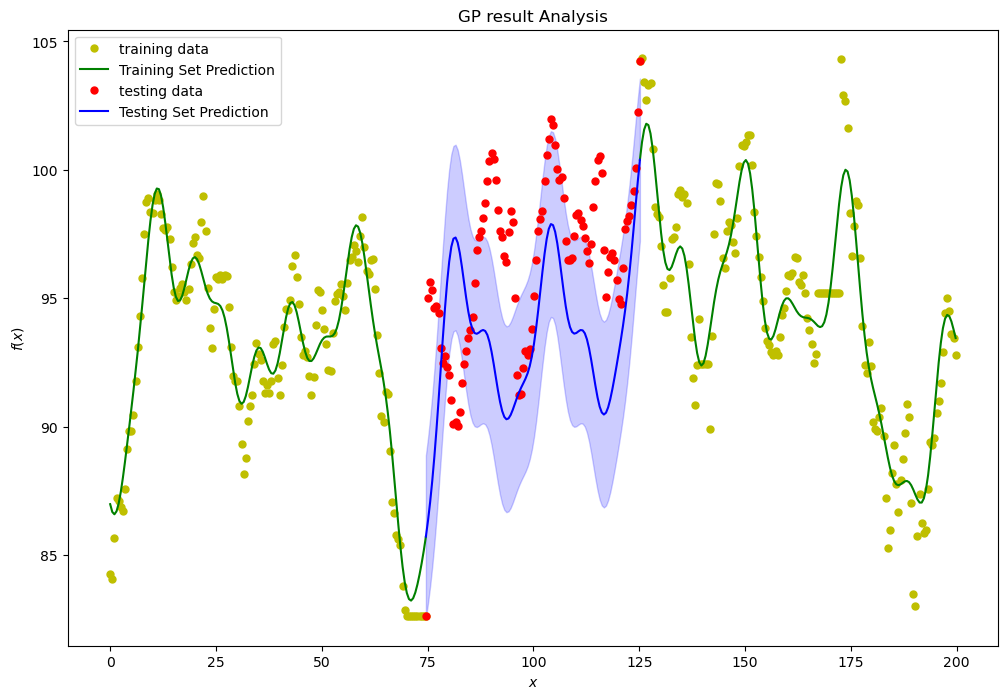

In [155]:
# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
plt.figure(figsize=(12,8))

#plot training data
plt.plot(X_train_with_nan, Y_train_with_nan, 'y.', markersize=10, label='training data')

#plot training prediction
plt.plot(X_train_with_nan, y_pred_train_with_nan, 'g-', label='Training Set Prediction')

#plot testing data
plt.plot(X_test, Y_test, 'r.', markersize=10, label='testing data')

#plot testing prediction
plt.plot(X_test, y_pred_test, 'b-', label='Testing Set Prediction')

#add CI
plt.fill_between(np.squeeze(X_test), (y_pred_test- ci).ravel(), (y_pred_test+ ci).ravel(), color='blue',alpha = 0.2)

plt.title('GP result Analysis')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.legend(loc='upper left')
plt.show()